In [1]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import pandas as pd

import joblib
import numpy as np

topic_dict = {
    0: 'Tech',
    1: 'Internationale Wahlen',
    2: 'Kunst & Literatur',
    3: 'Wetter & Fußball',
    4: 'Wirtschaft',
    5: 'Justiz',
    6: 'International',
    7: 'Ukrainekonflikt',
    8: 'Familie',
    9: 'Impfung',
    10: 'Interview',
    11: 'Innenpolitik',
    12: 'Wahlen in Deutschland',
    13: 'Parteienpolitik',
    14: 'Coronamaßnahmen',
}

media = [
    'junge Welt',
    "NachDenkSeiten",
    'taz',
    'Süddeutsche Zeitung',
    'stern TV',
    "DER SPIEGEL",
    'Der Tagesspiegel',
    'ARD',
    'Tagesschau',
    'ZDF',
    "ZDFheute Nachrichten",
    'Bayerischer Rundfunk',
    'ntv Nachrichten',
    'RTL',
    'FOCUS Online',
    'ZEIT ONLINE',
    'faz',
    'WELT',
    "BILD",
    'NZZ Neue Zürcher Zeitung',
    "Junge Freiheit",
    'COMPACTTV'
]

def define_print(verbose=True):
    if verbose:
        verboseprint = print
    else:
        verboseprint = lambda *args: None
    return verboseprint


def extract_topics(df, cv_model, lda_model, to_csv=True, verbose=True):
    verboseprint = define_print(verbose=verbose)
    df.dropna(inplace=True)

    verboseprint(f"getting topics for {df.shape[0]} videos...")
    lda = cv_model.transform(df["preprocessed"].to_list())
    lda = lda_model.transform(lda)
    lda = pd.DataFrame(lda)
    lda.rename(columns=topic_dict, inplace=True)
    dominant_topic_list = [topic_dict[topic] for topic in np.argmax(lda.values, axis=1)]
    dominant_topic_mask = np.max(lda.values, axis=1) < 0.3
    lda["dominant topic"] = dominant_topic_list
    lda.loc[dominant_topic_mask, "dominant topic"] = "None"

    # lda['dominant topic'] = lda.apply(lambda row: np.argmax(row.values) if np.max(row.values) > 0.3 else 'None')
    lda["id"] = df["id"].to_list()

    verboseprint("merging data...")
    df = df.merge(lda, how="outer", on="id")
    if to_csv:
        verboseprint("saving csv file...")
        df.to_csv("../data/labeled/" + df["medium"].iloc[0] + "_labeled.csv")
    return df


def sort_topics(dfs, to_csv=True, verbose=True):
    verboseprint = define_print(verbose=verbose)
    dfs_dict = {}

    verboseprint("initializing dataframes...")
    for _, topic in topic_dict.items():
        dfs_dict[topic] = pd.DataFrame()

    dfs_dict["None"] = pd.DataFrame()

    verboseprint(f"iterating through {len(dfs)} input dataframes...")
    for df in dfs:
        verboseprint("sorting " + df["medium"].iloc[0] + " dataframe by topic...")
        for _, topic in topic_dict.items():
            dfs_dict[topic] = pd.concat(
                [dfs_dict[topic], df[df["dominant topic"] == topic]]
            )
        dfs_dict["None"] = pd.concat(
            [dfs_dict["None"], df[df["dominant topic"] == "None"]]
        )

    if to_csv:
        verboseprint("saving csv files...")
        for _, topic in topic_dict.items():
            dfs_dict[topic].to_csv("../data/sorted/" + topic + ".csv")
        dfs_dict["None"].to_csv("../data/sorted/None.csv")

    return dfs_dict


def get_N_matrix(topic, verbose=True, drop_subsumed=True, drop_medium_specific=True):
    verboseprint = define_print(verbose=verbose)
    MEDIA = media
    cv = CountVectorizer(max_df=0.9, min_df=10, max_features=10000, ngram_range=(1, 3))

    verboseprint("importing dataframe with topic " + topic + " and fitting model...")
    df = pd.read_csv("../data/sorted/" + topic + ".csv", index_col=0)
    cv.fit(df["preprocessed"])

    verboseprint("restructuring dataframe with " + str(len(df)) + " transcripts...")
    df["preprocessed"] = df["preprocessed"] + " "
    df = df[["medium", "preprocessed", "dominant topic"]]
    df_grouped = df.groupby(["medium", "dominant topic"]).sum()

    df = pd.DataFrame(index=MEDIA, columns=["preprocessed"])
    empty_media = []
    for medium in MEDIA:
        try:
            df.loc[medium] = df_grouped.loc[medium].loc[topic]["preprocessed"]
        except:
            print(
                medium
                + " does not have any videos categorized under category '"
                + topic
                + "'."
            )
            df.drop(index=medium, inplace=True)
            empty_media.append(medium)

    for empty_medium in empty_media:
        MEDIA.remove(empty_medium)

    verboseprint("counting n-gram occurences...")
    N_matrix = cv.transform(df["preprocessed"].values)
    N_df = pd.DataFrame(
        data=N_matrix.toarray().transpose(),
        columns=df.index,
        index=cv.get_feature_names_out(),
    )

    if drop_medium_specific:
        verboseprint(
            "dropping medium-specific n-grams that occur in one medium at least 90% of the time..."
        )
        N_sum = N_df.sum(axis=1)
        mask = {}
        specific_mask = np.full(len(N_df.index), False)
        mask_df = N_df.apply(lambda x: x>0.9*N_sum)
        for medium in MEDIA:
            specific_mask = specific_mask | mask_df[medium].values
        N_df.drop(N_df.index[specific_mask], inplace=True)

    if drop_subsumed:
        N_df = N_df.reset_index().rename(columns={"index": "phrase"})
        N_df["n_gram"] = N_df["phrase"].apply(str.split).apply(len)
        N_df["count"] = N_df[MEDIA].sum(axis=1)

        monograms = N_df[N_df["n_gram"] == 1]
        bigrams = N_df[N_df["n_gram"] == 2]
        trigrams = N_df[N_df["n_gram"] == 3]
        bigram_words = list(
            set(
                [
                    word
                    for bigram_sublist in bigrams["phrase"].apply(str.split).tolist()
                    for word in bigram_sublist
                ]
            )
        )
        trigram_words = list(
            set(
                [
                    word
                    for trigram_sublist in trigrams["phrase"].apply(str.split).tolist()
                    for word in trigram_sublist
                ]
            )
        )

        verboseprint("extracting subsumed n-grams...")
        monograms_in_bigrams = monograms[monograms["phrase"].isin(bigram_words)]
        monograms_in_trigrams = monograms[monograms["phrase"].isin(trigram_words)]

        bigrams_in_trigrams_words = list(
            set(
                [
                    bigram_word
                    for bigram_word in bigram_words
                    if bigram_word in trigram_words
                ]
            )
        )
        bigrams_in_trigrams_mask = bigrams["phrase"].apply(
            lambda bigram: True
            if bigram.split()[0] in bigrams_in_trigrams_words
            or bigram.split()[1] in bigrams_in_trigrams_words
            else False
        )
        bigrams_in_trigrams = bigrams[bigrams_in_trigrams_mask]

        threshold = 0.7
        verboseprint(
            f"filtering n-grams which are subsumed more than {int(100*threshold)}% of the time..."
        )
        monograms_in_bigrams_above_threshold = list(
            set(
                [
                    monogram["phrase"]
                    for _, monogram in monograms_in_bigrams.iterrows()
                    for _, bigram in bigrams.iterrows()
                    if monogram["phrase"] in bigram["phrase"].split()
                    and bigram["count"] > threshold * monogram["count"]
                ]
            )
        )
        monograms_in_trigrams_above_threshold = list(
            set(
                [
                    monogram["phrase"]
                    for _, monogram in monograms_in_trigrams.iterrows()
                    for _, trigram in trigrams.iterrows()
                    if monogram["phrase"] in trigram["phrase"].split()
                    and trigram["count"] > threshold * monogram["count"]
                ]
            )
        )
        bigrams_in_trigrams_above_threshold = list(
            set(
                [
                    bigram["phrase"]
                    for _, bigram in bigrams_in_trigrams.iterrows()
                    for _, trigram in trigrams.iterrows()
                    if (
                        bigram["phrase"] in " ".join(trigram["phrase"].split()[:2])
                        or bigram["phrase"] in " ".join(trigram["phrase"].split()[-2:])
                    )
                    and trigram["count"] > threshold * bigram["count"]
                ]
            )
        )
        n_grams_above_threshold = list(
            set(
                np.append(
                    np.append(
                        monograms_in_bigrams_above_threshold,
                        monograms_in_trigrams_above_threshold,
                    ),
                    bigrams_in_trigrams_above_threshold,
                )
            )
        )

        N_df.drop(
            N_df[N_df["phrase"].isin(n_grams_above_threshold)].index, inplace=True
        )
        N_df.set_index("phrase", inplace=True)
        N_df.drop(columns=["n_gram", "count"], inplace=True)
    return N_df


def filter_N_by_information_score(N_df, n=1000, verbose=True):
    verboseprint = define_print(verbose=verbose)
    verboseprint("filtering " + str(n) + " most discriminative phrases from sample...")
    n_i = len(N_df.index)
    n_j = len(N_df.columns)
    P_ij = N_df / N_df.to_numpy().sum()
    P_i = P_ij.sum(axis=1)
    P_j = P_ij.sum(axis=0)

    I = np.zeros((n_i, n_j))

    for i in range(n_i):
        for j in range(n_j):
            I[i][j] = P_ij.values[i][j] * np.log2(P_ij.values[i][j] / P_i[i] / P_j[j])

    I = pd.DataFrame(I, index=N_df.index, columns=N_df.columns)
    I = I.fillna(0.0)
    I["sum"] = I.sum(axis=1)
    I.sort_values(by="sum", ascending=False, inplace=True)
    return N_df.loc[I.index[:n]]


In [2]:
topic = 'Justiz'
N_df = get_N_matrix(topic=topic)
N_df = filter_N_by_information_score(N_df)

N_df.to_csv('../data/N_matrices_pre_purge/N_'+topic+'_pre_purge.csv')

importing dataframe with topic Justiz and fitting model...
restructuring dataframe with 7405 transcripts...
Tagesschau does not have any videos categorized under category 'Justiz'.
counting n-gram occurences...
dropping medium-specific n-grams that occur in one medium at least 90% of the time...
extracting subsumed n-grams...
filtering n-grams which are subsumed more than 70% of the time...
filtering 1000 most discriminative phrases from sample...


/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_28725/2369764404.py:288: RuntimeWarning: divide by zero encountered in log2
  I[i][j] = P_ij.values[i][j] * np.log2(P_ij.values[i][j] / P_i[i] / P_j[j])
/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_28725/2369764404.py:288: RuntimeWarning: invalid value encountered in double_scalars
  I[i][j] = P_ij.values[i][j] * np.log2(P_ij.values[i][j] / P_i[i] / P_j[j])


Loading dataset...
done in 0.000s.
Extracting tf features for LDA...
done in 7.785s.
Fitting LDA models with tf features, n_features=10000...
done in 9.489s.


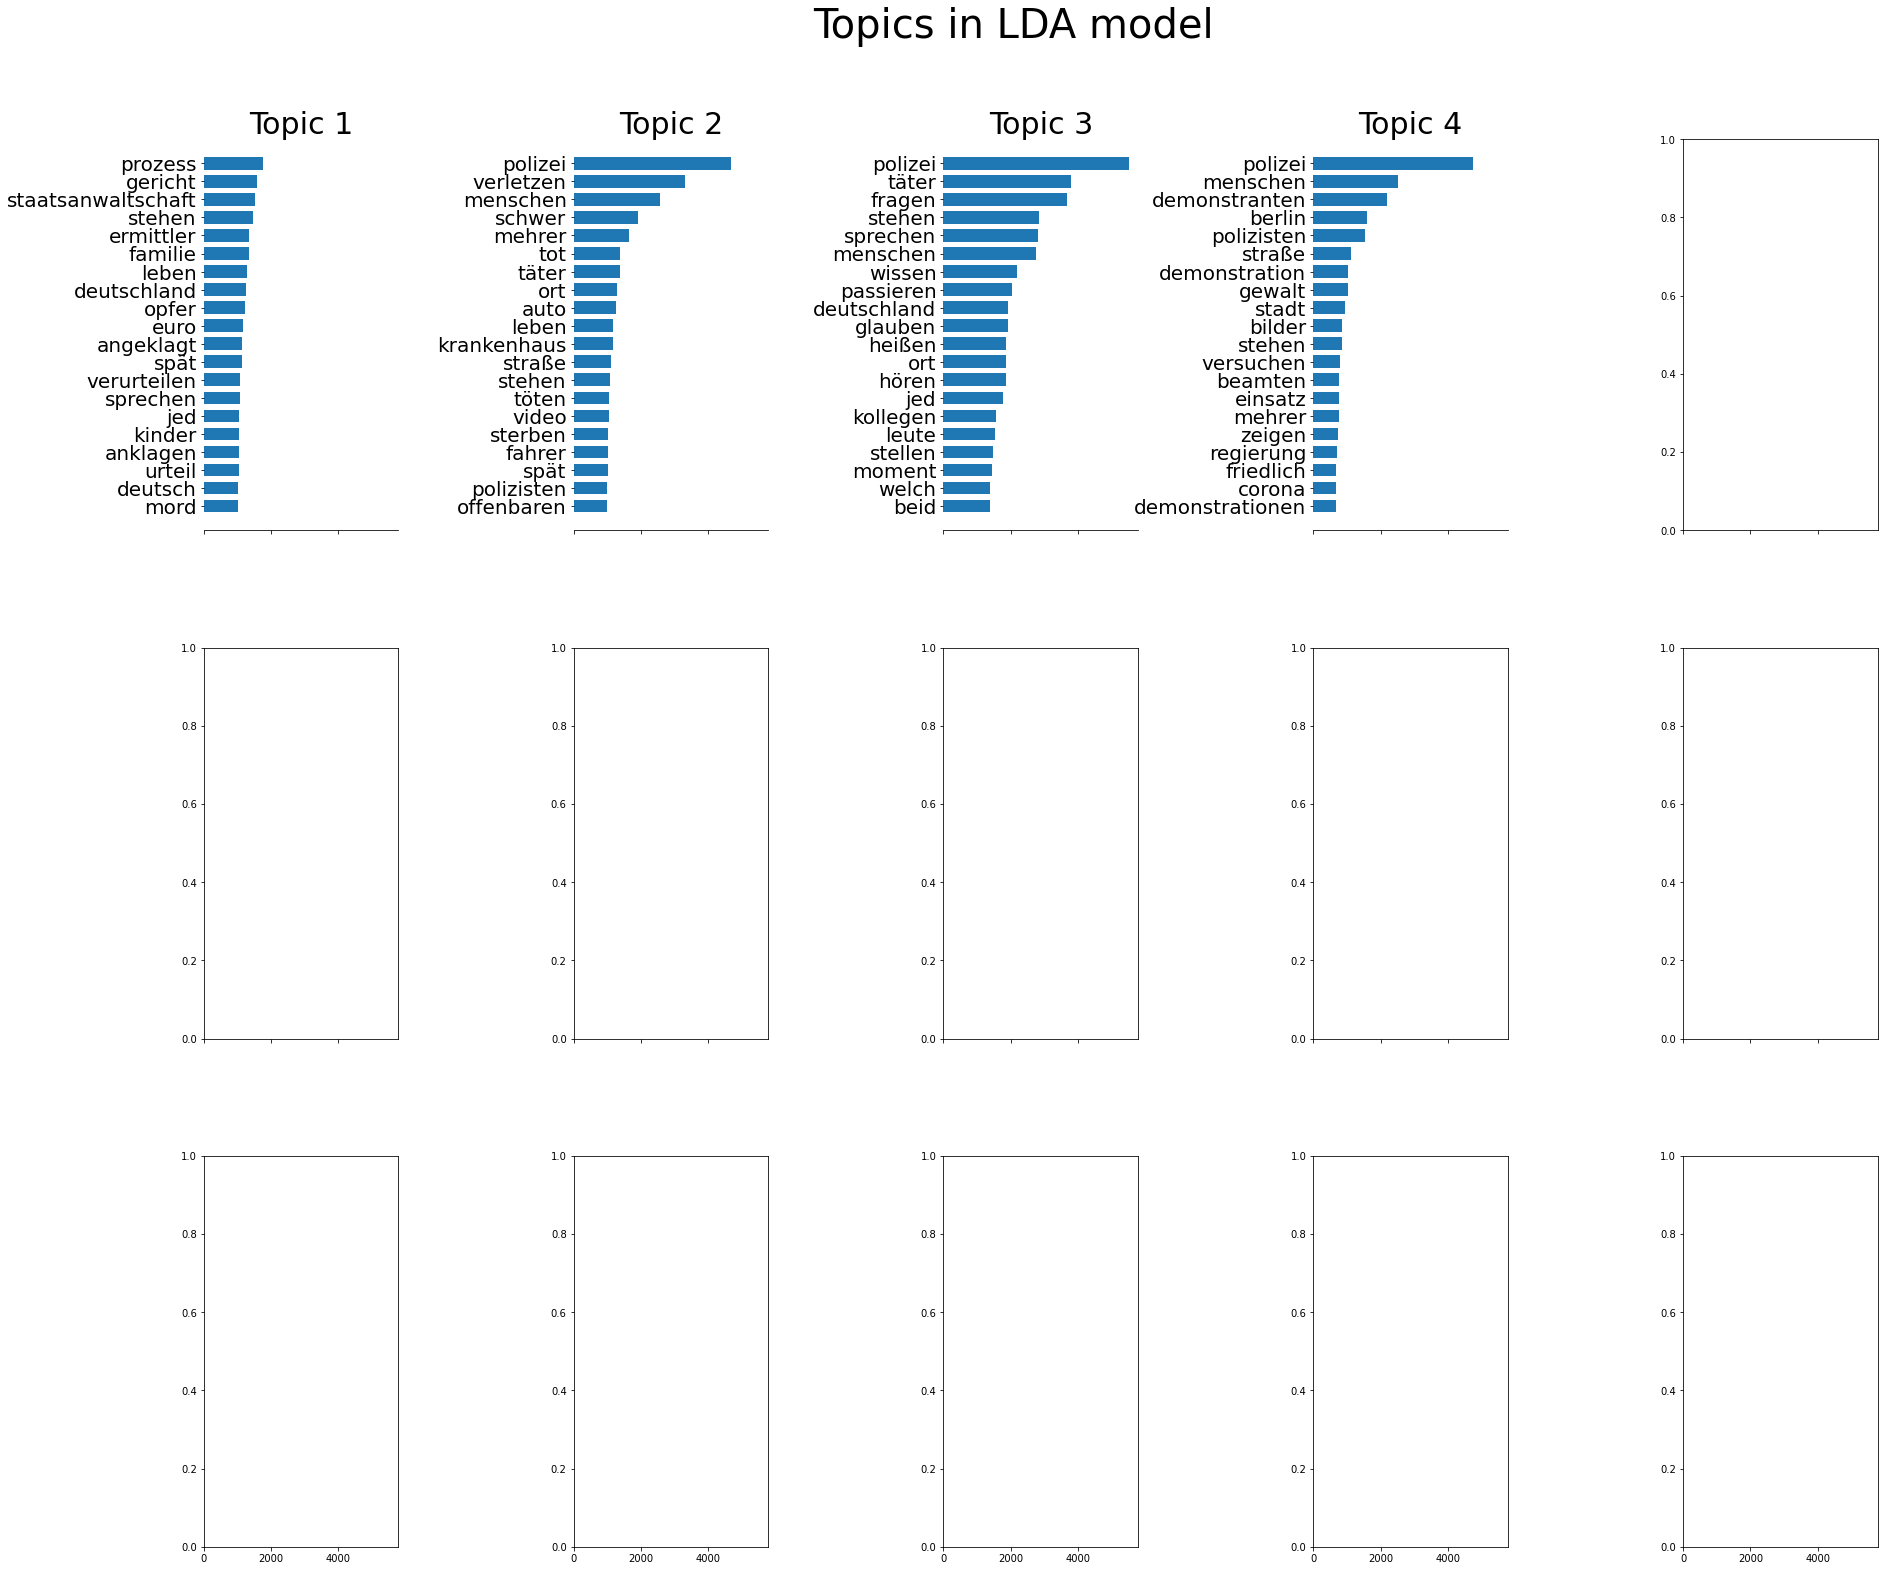

In [3]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import LatentDirichletAllocation

sample = pd.read_csv('../data/sorted/'+topic+'.csv', index_col=0)

n_features = 10000
n_components = 4
n_top_words = 20

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(3, 5, figsize=(30, 23), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

print("Loading dataset...")
t0 = time()
data = sample['preprocessed'].tolist()
data_samples = data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.9, min_df=10, max_features=n_features, stop_words='english', ngram_range=(1,3)
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print(
    "Fitting LDA models with tf features, n_features=%d..."
    % (n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=10,
    learning_method="online",
    learning_offset=50.0,
    learning_decay=0.6,
    random_state=0,
    n_jobs=-1
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")